In [1]:
import os
from os.path import exists

import anchor
# import anchor.anchor_tabular

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error

from sklearn.svm import SVC
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, f1_score, recall_score
from sklearn.inspection import DecisionBoundaryDisplay


import operator as op
from AnchorGeneration import *


In [2]:
data_path = "simulationVictorTopological/"
res_path = data_path+"resultsPSR_Safe/"
results_anchorfile = "anchors-csr.csv"
feature_labels = ['meanEntropy', 'medianEntropy',
       'stdsEntropy', 'iqrsEntropy']
true_output = "y_true"
cp_output = "y_conformal"
#model_output = "y_pred"

rules = pd.read_csv(res_path+results_anchorfile)

model = joblib.load(data_path+"CP_SVM_safe.sav")

test = pd.read_csv(data_path+"test_cp.csv")
y_test = np.array(test[true_output])
#y_model_test = np.array(test[model_output])
y_cp_test = np.array(test[cp_output])
X_test_df = test.drop([true_output,cp_output],axis = 1)
X_test = np.array(X_test_df)

In [3]:
test.describe()

,meanEntropy,medianEntropy,stdsEntropy,iqrsEntropy,y_true,y_conformal
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.673888,2.673621,0.029381,0.039531,0.208000,0.150000
std,0.023210,0.023577,0.005312,0.008189,0.978618,0.989181
min,2.605985,2.604250,0.017804,0.021600,-1.000000,-1.000000
25%,2.656237,2.655488,0.025625,0.034081,-1.000000,-1.000000
50%,2.676724,2.676175,0.028587,0.038275,1.000000,1.000000
75%,2.692575,2.692312,0.032392,0.043725,1.000000,1.000000
max,2.729245,2.732750,0.048488,0.074575,1.000000,1.000000


In [4]:
# visualize the anchors for all test set
rules

,Index,AnchorConditions,Coverage,Precision,AnchorOutput,ModelOutput,RealOutput
0,0,medianEntropy > 2.69,0.2452,0.934132,1.0,1.0,1.0
1,1,medianEntropy <= 2.65,0.2519,0.817190,-1.0,-1.0,-1.0
2,2,meanEntropy > 2.66,0.7478,0.623970,1.0,1.0,1.0
3,3,medianEntropy > 2.68,0.5010,0.839450,1.0,1.0,1.0
4,4,medianEntropy > 2.68,0.4965,0.818288,1.0,1.0,-1.0
...,...,...,...,...,...,...,...
933,995,meanEntropy <= 2.66,0.2576,0.754636,-1.0,-1.0,-1.0
934,996,medianEntropy > 2.65,0.7519,0.626269,1.0,1.0,-1.0
935,997,meanEntropy > 2.68,0.5001,0.810247,1.0,1.0,1.0
936,998,medianEntropy > 2.69,0.2416,0.908184,1.0,1.0,1.0


In [5]:
rules[rules["AnchorOutput"]==1]["AnchorConditions"].value_counts()

AnchorConditions
medianEntropy > 2.69    165
medianEntropy > 2.68    145
meanEntropy > 2.68       84
meanEntropy > 2.69       71
medianEntropy > 2.65     31
meanEntropy > 2.66       17
Name: count, dtype: int64

In [6]:
model.get_params()

{'alpha': array([ 4.99872383e-01, -2.30312013e-05, -7.37558808e-06, ...,
         5.00093371e-01,  5.00015073e-01, -1.54270367e-05]),
 'b': array([0.01518191]),
 'b_eps': 0.21313178659477316,
 'eta': 0.3,
 'kernel': 'gaussian',
 'param': 0.5,
 'tau': array([[0.5]]),
 'solver': 'osqp'}

# Candidate selection

Text(0, 0.5, 'Count')

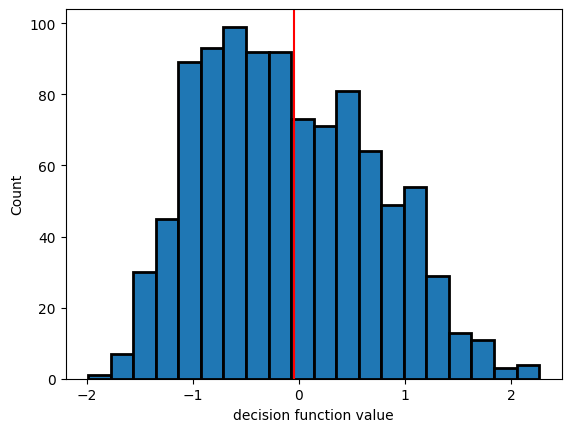

In [7]:
# distances of test points from decision boundary
d_test = model.decision_function(X_test)

plt.hist(d_test,bins = 20, edgecolor = "black",linewidth=2)
plt.gca().axvline(x=-0.05, color = "red")
plt.xlabel("decision function value")
plt.ylabel("Count")

In [8]:
min(d_test)

-1.9855212785407224

In [9]:
max(d_test)

2.2646666166833094

In [10]:
model.b_eps

0.21313178659477316

In [11]:
d_thresh = 0.05

border_points_idx = np.where((d_test < 0) & (abs(d_test) < d_thresh) & (y_cp_test == 1))[0]

print(f"# of candidate points: {len(border_points_idx)}")

# of candidate points: 19


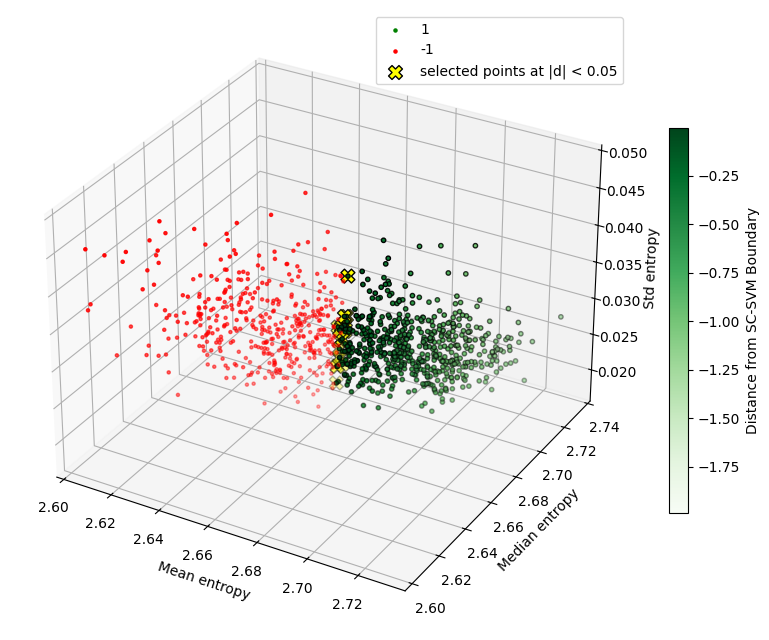

In [12]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='3d')

sc0 = ax.scatter3D(X_test[:,0][y_cp_test == -1], X_test[:,1][y_cp_test == -1], X_test[:,2][y_cp_test == -1], s=5, c= "red")
scsafe = ax.scatter3D(X_test[:,0][y_cp_test == 1], X_test[:,1][y_cp_test == 1], X_test[:,2][y_cp_test == 1], s=5, c= "green")

sc1 = ax.scatter3D(X_test[:,0][y_cp_test == 1], X_test[:,1][y_cp_test == 1], X_test[:,2][y_cp_test == 1], s=10, c=d_test[y_cp_test == 1], cmap = "Greens", edgecolors = "k")

sc2 = ax.scatter3D(X_test[list(border_points_idx),0],X_test[list(border_points_idx),1], X_test[list(border_points_idx),2],s=100, marker = 'X', facecolors="yellow", edgecolors="k")


ax.set_xlabel("Mean entropy")
ax.set_ylabel("Median entropy")
ax.set_zlabel("Std entropy")



ax.legend([scsafe, sc0,sc2], ["1","-1",f"selected points at |d| < {d_thresh}"], loc="upper right")
plt.colorbar(sc1, label = "Distance from SC-SVM Boundary", shrink = 0.5)

plt.show()

# Select the anchors for the candidate points

In [13]:
rule_cand_idx = np.array(rules[rules["Index"].isin(border_points_idx)==True].index)

In [14]:
# get rules generated on the selected boundary points
rules_candidates = rules.iloc[rule_cand_idx,:]

In [15]:
# focus on non collision class (label +1)
rules_noncoll = rules_candidates[rules_candidates["AnchorOutput"] == 1]
# '''
# # define a threshold for filtering on covering
# covering_threshold = 0.1

# rules_selected = rules_noncoll[rules_noncoll["Coverage"]>= covering_threshold]

# rules_selected = rules_selected.sort_values(by = ["Coverage"], axis = 0, ascending = False)

# rules_selected
# '''

In [16]:
rules_noncoll["AnchorConditions"].value_counts()

AnchorConditions
medianEntropy > 2.65    11
meanEntropy > 2.66       4
Name: count, dtype: int64

# Performance Evaluation


In [17]:
def evaluate_rules(data, tuned_rules, output):
    predictions_all = []
    for i, rule in tuned_rules.iterrows():
        pred_rule = []
        tptot = 0
        tntot = 0
        fntot = 0
        fptot = 0
        tuned_antecedent = rule['AnchorConditions'].strip()
        print(f"rule: {tuned_antecedent}")
        for _, row in data.iterrows():
            y_row = row[output]
            tp = 0
            tn = 0
            fn = 0
            fp = 0
            # check if the point row satifies rule 
            if evaluate_rule_conditions(row, tuned_antecedent):
                # rule is satisfied
                satisfied = True
                pred_rule.append(1)
            else:
                satisfied = False
                pred_rule.append(-1)
    
            
            if satisfied and y_row == 1:
                tp=1
            elif satisfied and y_row == -1:
                fp=1
            elif not satisfied and y_row == -1:
                tn=1
            
            elif not satisfied and y_row == 1:
                fn=1
            predictions_all.append(pred_rule)
            tptot+=tp
            tntot+=tn
            fptot+=fp
            fntot+=fn

        
        print(f"tp = {tptot}, tn = {tntot}, fp = {fptot}, fn = {fntot}")
        prec = tptot / (tptot+fptot)
        cov = tptot/(tptot+fntot)
        acc = (tptot+tntot)/(tptot+tntot+fptot+fntot)
        f1score = (2*tptot)/(2*tptot+fptot+fntot)
        err = fptot/(tntot+fptot)
        print(f"precision: {prec}, covering: {cov}, error: {err}, accuracy: {acc}, f1: {f1score}\n")          

    return predictions_all


def evaluate_rule_conditions(row, condition_part):

    # Checks if any of the conditions in the rule are satisfied
    if all(check_condition(row, part) for part in condition_part.split(" AND ")):
        return True  # Return True if all conditions in the rule are satisfied
    
    return False  # Return False if any of the conditions in the rule is not satisfied


def check_condition(row, condition_part):
    # Check if a single condition part is satisfied
    
    parts = [part.strip('()') for part in condition_part.split()]
    #print("parts: ", parts)
    if len(parts) == 3:
        column, op, value = parts
        return eval(f"{row[column]} {op} {value}")
    # handle the case of a 2-thresholds conditions of the kind: a < Column <= b
    elif len(parts) == 5:
        val1,op1,column,op2,val2 = parts
        # Use the original condition from the rule
        return eval(f"{val1} {op1} {row[column]} {op2} {val2}")        
    else:
        # Handle cases where the condition is not in the expected format
        pass

# SafetyMargin > 0.05 AND Tau <= 0.25 AND Eta > 0.25


In [18]:
rules_noncoll_unique = rules_noncoll.drop_duplicates(subset = "AnchorConditions")
rules_noncoll_unique

,Index,AnchorConditions,Coverage,Precision,AnchorOutput,ModelOutput,RealOutput
64,67,meanEntropy > 2.66,0.7525,0.615341,1.0,1.0,1.0
343,367,medianEntropy > 2.65,0.7494,0.606212,1.0,1.0,1.0


# Evaluation on true labels

In [19]:
preds_by_rule = evaluate_rules(test, rules_noncoll_unique, true_output)

rule: meanEntropy > 2.66
tp = 580, tn = 268, fp = 128, fn = 24
precision: 0.8192090395480226, covering: 0.9602649006622517, error: 0.32323232323232326, accuracy: 0.848, f1: 0.8841463414634146

rule: medianEntropy > 2.65
tp = 602, tn = 180, fp = 216, fn = 2
precision: 0.7359413202933985, covering: 0.9966887417218543, error: 0.5454545454545454, accuracy: 0.782, f1: 0.8466947960618847



# evaluation on safety checker labels

In [20]:
preds_by_rule_cp = evaluate_rules(test, rules_noncoll_unique, cp_output)

rule: meanEntropy > 2.66
tp = 575, tn = 292, fp = 133, fn = 0
precision: 0.8121468926553672, covering: 1.0, error: 0.3129411764705882, accuracy: 0.867, f1: 0.8963367108339828

rule: medianEntropy > 2.65
tp = 575, tn = 182, fp = 243, fn = 0
precision: 0.7029339853300733, covering: 1.0, error: 0.571764705882353, accuracy: 0.757, f1: 0.8255563531945441



**Evaluate the $\lor$ of the rules**

In [21]:
verified1 = (X_test[:,0] > 2.66) 

verified2 = (X_test[:,1] > 2.65) 

verified_or = verified1|verified2

prec, cov, acc, fscore,err = ComputeMetricsForRule(verified_or, y_test)
print(f"precision: {prec}, covering: {cov}, accuracy: {acc}, f1: {fscore}, error: {err}")  

tp = 602, tn = 180, fp = 216, fn = 2
precision: 0.7359413202933985, covering: 0.9966887417218543, accuracy: 0.782, f1: 0.8466947960618847, error: 0.26405867970660146


In [22]:
prec, cov, acc, fscore,err = ComputeMetricsForRule(verified_or, y_cp_test)
print(f"precision: {prec}, covering: {cov}, accuracy: {acc}, f1: {fscore}, error: {err}")   

tp = 575, tn = 182, fp = 243, fn = 0
precision: 0.7029339853300733, covering: 1.0, accuracy: 0.757, f1: 0.8255563531945441, error: 0.29706601466992666
